In [16]:
import numpy as np
import matplotlib.pyplot as plt

def clean_normalize(time, flux, flux_err=None):
    """Remove NaNs and simple-normalize flux to median per segment."""
    m = np.isfinite(time) & np.isfinite(flux)
    if flux_err is not None:
        m &= np.isfinite(flux_err)
    t, y = time[m], flux[m]
    ye = flux_err[m] if flux_err is not None else None

    # split at big gaps (new sector) and median-normalize each piece
    gaps = np.where(np.diff(t) > 0.5)[0]  # >0.5 d ~ sector break
    idx = np.r_[0, gaps + 1, t.size]
    for i in range(len(idx)-1):
        s = slice(idx[i], idx[i+1])
        med = np.nanmedian(y[s])
        if np.isfinite(med) and med != 0:
            y[s] /= med
            if ye is not None:
                ye[s] /= med
    return t, y, ye

def phase_fold(time, period, t0):
    """Return phase in range [-0.5, 0.5)."""
    phase = ((time - t0 + 0.5*period) % period) / period - 0.5
    return phase

def binned(x, y, nbins=100):
    """Simple equal-width binning with nanmedian."""
    edges = np.linspace(x.min(), x.max(), nbins+1)
    xc = 0.5*(edges[:-1] + edges[1:])
    yb = np.full(nbins, np.nan)
    for i in range(nbins):
        m = (x >= edges[i]) & (x < edges[i+1])
        if np.any(m):
            yb[i] = np.nanmedian(y[m])
    return xc, yb

def plot_phase_fold(time, flux, flux_err=None, period=1.8099, t0=None):
    if t0 is None:
        # pick a reasonable reference (near first cadence)
        t0 = time[0]
    ph = phase_fold(time, period, t0)
    # make a double panel: scatter and binned
    plt.figure()
    if flux_err is not None:
        plt.errorbar(ph, flux, yerr=flux_err, fmt=".", ms=2, alpha=0.5)
    else:
        plt.plot(ph, flux, ".", ms=2, alpha=0.5)
    xc, yb = binned(ph, flux, nbins=120)
    plt.plot(xc, yb, "-", lw=2)
    plt.xlim(-0.15, 0.15)   # focus around transit; widen if needed
    plt.xlabel("Phase (periods)")
    plt.ylabel("Normalized Flux")
    plt.title("Phase-folded light curve")
    plt.tight_layout()
    plt.show()

def plot_single_transit(time, flux, period=1.8099, t0=None, half_window_hours=3):
    """Zoom to the transit nearest t0 (or first transit)."""
    if t0 is None:
        t0 = time[0]
    # find nearest transit center to the middle of dataset
    tref = np.nanmedian(time)
    k = np.round((tref - t0)/period)
    tcenter = t0 + k*period
    win = half_window_hours/24.0
    m = (time >= tcenter - win) & (time <= tcenter + win)
    if not np.any(m):
        print("Could not find points near a predicted transit; try a different t0.")
        return
    plt.figure()
    plt.plot((time[m]-tcenter)*24.0, flux[m], ".", ms=3)
    plt.axvline(0, ls="--")
    plt.xlabel("Hours from transit center")
    plt.ylabel("Normalized Flux")
    plt.title("Single-transit zoom")
    plt.tight_layout()
    plt.show()


Orbital period in days [default 1.8099]: 1.80988132
Reference mid-transit time BTJD (leave blank to auto-pick): 


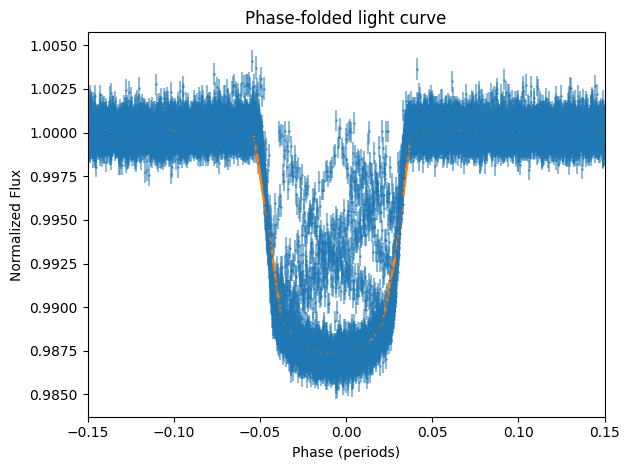

No points near predicted transit; try a different t0.


In [22]:
# after reading TIME, PDCSAP_FLUX (preferred) or SAP_FLUX
t, y, ye = clean_normalize(time, flux, flux_err)

# Ask for ephemeris (defaults are fine for WASP-76 b)
try:
    P_in = input("Orbital period in days [default 1.8099]: ").strip()
    P = float(P_in) if P_in else 1.8099
except ValueError:
    P = 1.8099

t0_in = input("Reference mid-transit time BTJD (leave blank to auto-pick): ").strip()
t0 = float(t0_in) if t0_in else None

# 1) Phase-folded view
plot_phase_fold(t, y, ye, period=P, t0=t0)

# 2) Zoom on one transit (≈3 h half-window is typical for hot Jupiters)
plot_single_transit(t, y, period=P, t0=t0, half_window_hours=3)


In [19]:
from astropy.io import fits

# Example: Load data from one of the available FITS files
fits_file = '/content/WASP-76_b_pdcsap.fits'

with fits.open(fits_file) as hdul:
    # Assuming the data is in the first extension (often the case for light curves)
    data = hdul[1].data
    time = data['TIME']
    flux = data['FLUX'] # Using FLUX as found in the file
    flux_err = data['FLUX_ERR'] # Using FLUX_ERR as found in the file

In [20]:
from astropy.io import fits

fits_file = '/content/WASP-76_b_pdcsap.fits'

with fits.open(fits_file) as hdul:
    hdul.info()
    print(hdul[1].columns.names)

Filename: /content/WASP-76_b_pdcsap.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  LIGHTCURVE    1 BinTableHDU     26   43203R x 7C   [D, E, E, J, D, D, J]   
['TIME', 'FLUX', 'FLUX_ERR', 'CADENCENO', 'MOM_CENTR1', 'MOM_CENTR2', 'QUALITY']


LIGHT CURVE DISPLAYER — local/zip + phase binning
Path to a FITS file, a folder, or a MAST .zip: /content/WASP-76_b_pdcsap.fits
Filename keywords / TIC / name (e.g., 'trappist 153732096 s0042'): wasp-76b
Show error bars in bin error band? (y/N): y
Orbital period in days [default 1.8099]: 1.80988132
Reference mid-transit time BTJD (blank = auto): 


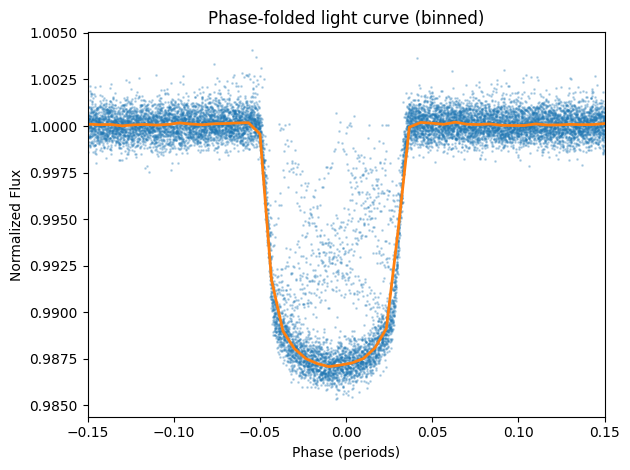

No points near predicted transit; try a different t0.


In [21]:


import os, re, io, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


NAME_TO_TIC = {
    "trappist-1": "153732096",
    "trappist1":  "153732096",
    "wasp-76":    "275969174",
    "wasp-76b":   "275969174",
}



def score_name(name: str):
    """Rank candidates: HLSP LC > mission LC > TPF > everything else."""
    n = name.lower()
    if n.startswith("hlsp_tess-spoc") and n.endswith("_lc.fits"): return (3, -len(n))
    if n.endswith("_s_lc.fits"):                                 return (2, -len(n))
    if n.endswith("_tp.fits") or n.endswith("_s_tp.fits"):        return (1, -len(n))
    return (0, -len(n))

def zero_pad_tic(tic: str) -> str:
    return str(int(tic)).zfill(16)

def matches_query(name: str, query: str) -> bool:
    """Match if all tokens appear in filename (case-insensitive)."""
    tokens = [t for t in re.split(r"[ ,;:_\-]+", query.strip()) if t]
    low = name.lower()
    return all(tok.lower() in low for tok in tokens)

def find_in_folder(root: Path, query: str) -> list[Path]:
    hits = []
    for p in root.rglob("*.fits"):
        if matches_query(p.name, query):
            hits.append(p)
    hits.sort(key=lambda p: score_name(p.name), reverse=True)
    return hits

def find_in_zip(zip_path: Path, query: str) -> list[str]:
    hits = []
    with zipfile.ZipFile(zip_path) as z:
        for name in z.namelist():
            if name.lower().endswith(".fits") and matches_query(os.path.basename(name), query):
                hits.append(name)
    hits.sort(key=lambda n: score_name(os.path.basename(n)), reverse=True)
    return hits

def open_fits_from_zip(zip_path: Path, internal_name: str):
    """Return (HDUList, label) opened directly from file inside zip."""
    with zipfile.ZipFile(zip_path) as z:
        with z.open(internal_name) as fh:
            data = fh.read()
    return fits.open(io.BytesIO(data), mode="readonly"), os.path.basename(internal_name)



def pick_flux_columns(hdu):
    cols = hdu.data.columns.names
    if "PDCSAP_FLUX" in cols:
        return "PDCSAP_FLUX", "PDCSAP_FLUX_ERR" if "PDCSAP_FLUX_ERR" in cols else None
    if "SAP_FLUX" in cols:
        return "SAP_FLUX", "SAP_FLUX_ERR" if "SAP_FLUX_ERR" in cols else None
    for c in cols:
        if c not in ("TIME", "QUALITY", "CADENCENO"):
            return c, None
    return cols[0], None

def clean_normalize(time, flux, flux_err=None):
    """Remove NaNs and median-normalize each time segment (per sector)."""
    m = np.isfinite(time) & np.isfinite(flux)
    if flux_err is not None:
        m &= np.isfinite(flux_err)
    t, y = np.asarray(time[m], float), np.asarray(flux[m], float)
    ye = np.asarray(flux_err[m], float) if flux_err is not None else None


    gaps = np.where(np.diff(t) > 0.5)[0]
    idx = np.r_[0, gaps + 1, t.size]
    for i in range(len(idx)-1):
        s = slice(idx[i], idx[i+1])
        med = np.nanmedian(y[s])
        if np.isfinite(med) and med != 0:
            y[s] /= med
            if ye is not None:
                ye[s] /= med
    return t, y, ye

def phase_from(time, period, t0):
    return ((time - t0 + 0.5*period) % period) / period - 0.5

def phase_bin(phase, flux, flux_err=None, nbins=120, clip_sigma=3.0):
    """Median bin with simple MAD sigma-clip; returns centers, med, SEM."""
    ph = ((phase + 0.5) % 1.0) - 0.5
    m = np.isfinite(ph) & np.isfinite(flux)
    if flux_err is not None:
        m &= np.isfinite(flux_err)
    ph, y = ph[m], flux[m]

    edges = np.linspace(-0.5, 0.5, nbins+1)
    centers = 0.5*(edges[:-1] + edges[1:])
    y_med = np.full(nbins, np.nan)
    y_sem = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (ph >= edges[i]) & (ph < edges[i+1])
        if not np.any(sel): continue
        vals = y[sel]
        if clip_sigma is not None and np.isfinite(vals).sum() > 5:
            med = np.nanmedian(vals)
            mad = 1.4826*np.nanmedian(np.abs(vals - med))
            keep = np.abs(vals - med) < clip_sigma*mad if mad > 0 else np.isfinite(vals)
            vals = vals[keep]
        if vals.size == 0: continue
        y_med[i] = np.nanmedian(vals)
        y_sem[i] = np.nanstd(vals) / np.sqrt(np.sum(np.isfinite(vals)))
    return centers, y_med, y_sem

def plot_phase_binned(time, flux, flux_err=None, period=1.8099, t0=None, nbins=150):
    if t0 is None: t0 = time[0]
    phase = phase_from(time, period, t0)

    plt.figure()
    # raw scatter (light)
    plt.plot(phase, flux, ".", ms=2, alpha=0.25)
    # binned curve
    xc, yb, ysem = phase_bin(phase, flux, flux_err, nbins=nbins, clip_sigma=3.0)
    plt.plot(xc, yb, "-", lw=2)
    if np.isfinite(ysem).any():
        plt.fill_between(xc, yb - ysem, yb + ysem, alpha=0.3, linewidth=0)
    plt.xlim(-0.15, 0.15)
    plt.xlabel("Phase (periods)")
    plt.ylabel("Normalized Flux")
    plt.title("Phase-folded light curve (binned)")
    plt.tight_layout()
    plt.show()

def plot_single_transit(time, flux, period=1.8099, t0=None, half_window_hours=3):
    if t0 is None: t0 = time[0]
    tref = np.nanmedian(time)
    k = np.round((tref - t0)/period)
    tcenter = t0 + k*period
    win = half_window_hours/24.0
    m = (time >= tcenter - win) & (time <= tcenter + win)
    if not np.any(m):
        print("No points near predicted transit; try a different t0.")
        return
    plt.figure()
    plt.plot((time[m]-tcenter)*24.0, flux[m], ".", ms=3)
    plt.axvline(0, ls="--")
    plt.xlabel("Hours from transit center")
    plt.ylabel("Normalized Flux")
    plt.title("Single-transit zoom")
    plt.tight_layout()
    plt.show()



def main():
    print("LIGHT CURVE DISPLAYER — local/zip + phase binning")
    source = input("Path to a FITS file, a folder, or a MAST .zip: ").strip()
    query  = input("Filename keywords / TIC / name (e.g., 'trappist 153732096 s0042'): ").strip()
    use_err = input("Show error bars in bin error band? (y/N): ").strip().lower() == "y"

    p = Path(source).expanduser()
    if not p.exists():
        print("Path does not exist."); return


    if p.is_file() and p.suffix.lower() == ".fits":
        fits_label = p.name
        hdul = fits.open(p)
    else:
        q = query
        key = query.strip().lower()
        m = re.fullmatch(r"\d{6,}", key)
        if key in NAME_TO_TIC:
            q = zero_pad_tic(NAME_TO_TIC[key])
        elif m:
            q = zero_pad_tic(m.group(0))
        if p.is_dir():
            found = find_in_folder(p, q)
            if not found:
                print("No matching FITS found in folder."); return
            print("Using:", found[0].name)
            fits_label = found[0].name
            hdul = fits.open(found[0])
        elif p.is_file() and p.suffix.lower() == ".zip":
            internal = find_in_zip(p, q)
            if not internal:
                print("No matching FITS inside zip."); return
            print("Using (inside zip):", os.path.basename(internal[0]))
            hdul, fits_label = open_fits_from_zip(p, internal[0])
        else:
            print("Provide a folder, a .fits file, or a .zip file."); return

    lc = next((h for h in hdul if getattr(h, "name", "").upper() == "LIGHTCURVE"), None)
    if lc is None:
        print("No LIGHTCURVE extension in", fits_label); hdul.close(); return

    hdr = lc.header
    t = np.array(lc.data["TIME"], dtype=float)
    flux_col, err_col = pick_flux_columns(lc)
    y = np.array(lc.data[flux_col], dtype=float)
    ye = np.array(lc.data[err_col], dtype=float) if (err_col and err_col in lc.data.columns.names) else None

    t, y, ye = clean_normalize(t, y, ye)

    # Ask for ephemeris (defaults is WASP-76 b)
    try:
        P_in = input("Orbital period in days [default 1.8099]: ").strip()
        P = float(P_in) if P_in else 1.8099
    except ValueError:
        P = 1.8099
    t0_in = input("Reference mid-transit time BTJD (blank = auto): ").strip()
    t0 = float(t0_in) if t0_in else None

    # Plots
    plot_phase_binned(t, y, flux_err=ye if use_err else None, period=P, t0=t0, nbins=150)
    plot_single_transit(t, y, period=P, t0=t0, half_window_hours=3)

    hdul.close()

if __name__ == "__main__":
    main()
